In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import seaborn as sns
from google.colab import drive
from tensorflow.keras.layers import GlobalAveragePooling2D
#from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
#from tensorflow.keras.applications import InceptionV3
#from tensorflow.keras.applications import ResNet152
#from tensorflow.keras.applications import Xception
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,precision_recall_fscore_support,precision_score,recall_score,f1_score
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler,EarlyStopping

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
img_height, img_width = 512, 512
data_dir = '/content/gdrive/MyDrive/kidney'
class_names = sorted(os.listdir(data_dir))

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

images = []
labels = []

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
        image = tf.keras.preprocessing.image.img_to_array(image)

        # Apply data augmentation
        image = datagen.random_transform(image)

        image = tf.keras.applications.efficientnet.preprocess_input(image)
        images.append(image)
        labels.append(class_idx)

images = np.array(images)
labels = np.array(labels)

In [ ]:
base_model1 = VGG16(weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model1.output)
efficientnet_model = tf.keras.models.Model(inputs=base_model1.input, outputs=x)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
def evaluate(y_true,y_pred,model):
  accuracy = accuracy_score(y_true,y_pred)
  print(f"Evaluation result for {model}")
  print("****************************")
  print('Classification report')
  print(classification_report(y_true,y_pred))
  true_labels = y_true
  predicted_labels = y_pred
  num_classes = 5
  precision_scores = {}
  recall_scores = {}
  f1_scores = {}
  accuracy_scores = {}
  zero_division = 1
  for class_label in range(num_classes):
      true_class = [1 if label == class_label else 0 for label in true_labels]
      predicted_class = [1 if label == class_label else 0 for label in predicted_labels]

      precision = precision_score(true_class, predicted_class, zero_division=zero_division)
      recall = recall_score(true_class, predicted_class, zero_division=zero_division)
      f1 = f1_score(true_class, predicted_class, zero_division=zero_division)
      acc = accuracy_score(true_class,predicted_class)

      precision_scores[class_label] = precision
      recall_scores[class_label] = recall
      f1_scores[class_label] = f1
      accuracy_scores[class_label] = acc

  for class_label in range(num_classes):
      print(f"Class {class_label}:")
      print(f"Accuracy: {accuracy_scores[class_label]:.2f}")
      print(f"Precision: {precision_scores[class_label]:.2f}")
      print(f"Recall: {recall_scores[class_label]:.2f}")
      print(f"F1 Score: {f1_scores[class_label]:.2f}")

      print("=" * 20)

  macro_precision = sum(precision_scores.values()) / len(precision_scores)
  macro_recall = sum(recall_scores.values()) / len(recall_scores)
  macro_f1 = sum(f1_scores.values()) / len(f1_scores)

  micro_precision = precision_score(true_labels, predicted_labels, average='micro')
  micro_recall = recall_score(true_labels, predicted_labels, average='micro')
  micro_f1 = f1_score(true_labels, predicted_labels, average='micro')

  print("Macro Averages:")
  print(f"Macro Precision: {macro_precision:.2f}")
  print(f"Macro Recall: {macro_recall:.2f}")
  print(f"Macro F1 Score: {macro_f1:.2f}")

  print("Micro Averages:")
  print(f"Micro Precision: {micro_precision:.2f}")
  print(f"Micro Recall: {micro_recall:.2f}")
  print(f"Micro F1 Score: {micro_f1:.2f}")
  print(f'\n\nAccuracy: {accuracy}\n\n')
  comat = confusion_matrix(y_true,y_pred)
  sns.heatmap(comat,annot=True)
  return [accuracy,accuracy_scores,precision_scores,recall_scores,f1_scores]

In [ ]:
def plot_history(history):
  pd.DataFrame(history.history).plot()

In [ ]:
img_eff = efficientnet_model.predict(images)

16/16 [==============================] - 41s 1s/step


In [ ]:
num_features = img_eff.shape[1]
print("Number of features extracted by ResNet152: ",num_features)

Number of features extracted by ResNet152:  512


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(img_eff,labels,test_size=0.2,random_state=42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(128,3,activation='relu',input_shape=(x_train.shape[1],1)),
    tf.keras.layers.MaxPool1D(2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(64,3,activation='relu'),
    tf.keras.layers.MaxPool1D(2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(64,3,activation='relu'),
    tf.keras.layers.MaxPool1D(2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(5,activation='softmax')
])

In [ ]:
model1.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
rf.fit(x_train,y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred_rf = rf.predict(x_test)

Evaluation result for ResNet152 + RandomForest
****************************
Classification report
              precision    recall  f1-score   support

           1       0.95      0.68      0.79        28
           2       0.57      0.94      0.71        18
           3       0.81      0.68      0.74        25
           4       0.79      0.79      0.79        29

    accuracy                           0.76       100
   macro avg       0.78      0.77      0.76       100
weighted avg       0.80      0.76      0.76       100

Class 0:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Class 1:
Accuracy: 0.90
Precision: 0.95
Recall: 0.68
F1 Score: 0.79
Class 2:
Accuracy: 0.86
Precision: 0.57
Recall: 0.94
F1 Score: 0.71
Class 3:
Accuracy: 0.88
Precision: 0.81
Recall: 0.68
F1 Score: 0.74
Class 4:
Accuracy: 0.88
Precision: 0.79
Recall: 0.79
F1 Score: 0.79
Macro Averages:
Macro Precision: 0.82
Macro Recall: 0.82
Macro F1 Score: 0.81
Micro Averages:
Micro Precision: 0.76
Micro Recal

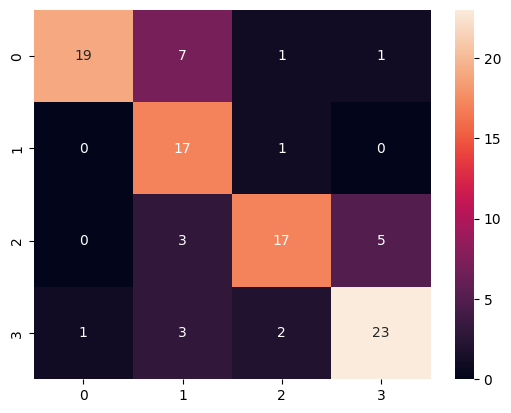

In [ ]:
lst_rf = evaluate(y_test,y_pred_rf,"ResNet152 + RandomForest")
acc_rf = lst_rf[0]
acc_rf_classes = lst_rf[1]
pre_rf = lst_rf[2]
rec_rf = lst_rf[3]
fscore_rf = lst_rf[4]

In [ ]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

In [ ]:
history = model.fit(x_train,y_train_encoded,validation_data=(x_test,y_test_encoded),epochs=50)

Epoch 1/50
13/13 [==============================] - 4s 23ms/step - loss: 1.7757 - accuracy: 0.2306 - val_loss: 1.5058 - val_accuracy: 0.3000
Epoch 2/50
13/13 [==============================] - 0s 7ms/step - loss: 1.5218 - accuracy: 0.2882 - val_loss: 1.4822 - val_accuracy: 0.2800
Epoch 3/50
13/13 [==============================] - 0s 7ms/step - loss: 1.5145 - accuracy: 0.2882 - val_loss: 1.4240 - val_accuracy: 0.2900
Epoch 4/50
13/13 [==============================] - 0s 8ms/step - loss: 1.4339 - accuracy: 0.3208 - val_loss: 1.3876 - val_accuracy: 0.3700
Epoch 5/50
13/13 [==============================] - 0s 7ms/step - loss: 1.4196 - accuracy: 0.2882 - val_loss: 1.2942 - val_accuracy: 0.4900
Epoch 6/50
13/13 [==============================] - 0s 6ms/step - loss: 1.4089 - accuracy: 0.3033 - val_loss: 1.2124 - val_accuracy: 0.5200
Epoch 7/50
13/13 [==============================] - 0s 7ms/step - loss: 1.3469 - accuracy: 0.3860 - val_loss: 1.2542 - val_accuracy: 0.4400
Epoch 8/50
13/13 [=

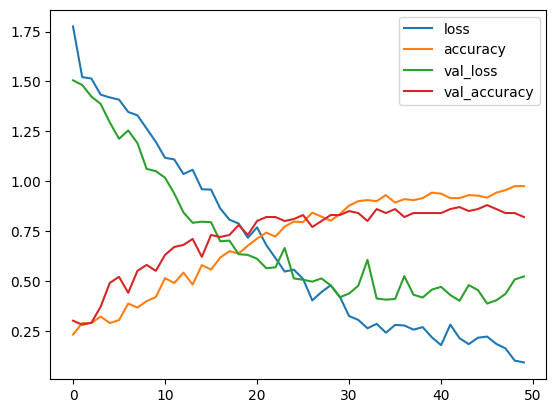

In [ ]:
plot_history(history)

4/4 [==============================] - 0s 4ms/step
Evaluation result for Resnet152+ANN
****************************
Classification report
              precision    recall  f1-score   support

           1       0.81      0.93      0.87        28
           2       0.74      0.78      0.76        18
           3       0.88      0.84      0.86        25
           4       0.84      0.72      0.78        29

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.81       100
weighted avg       0.82      0.82      0.82       100

Class 0:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Class 1:
Accuracy: 0.92
Precision: 0.81
Recall: 0.93
F1 Score: 0.87
Class 2:
Accuracy: 0.91
Precision: 0.74
Recall: 0.78
F1 Score: 0.76
Class 3:
Accuracy: 0.93
Precision: 0.88
Recall: 0.84
F1 Score: 0.86
Class 4:
Accuracy: 0.88
Precision: 0.84
Recall: 0.72
F1 Score: 0.78
Macro Averages:
Macro Precision: 0.85
Macro Recall: 0.85
Macro F1 Score: 0.85
Micro Ave

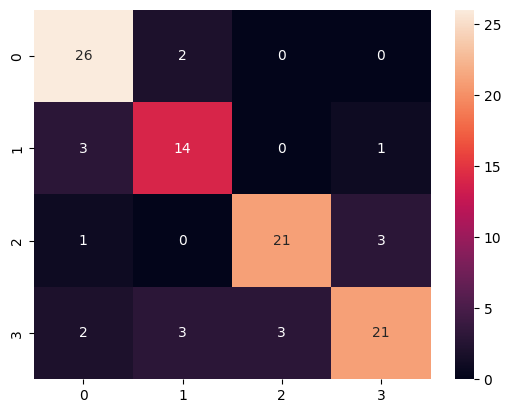

In [ ]:
y_preps1 = model.predict(x_test)
y_preds1 = np.argmax(y_preps1,axis=1)

lst_ann = evaluate(y_test,y_preds1,"Resnet152+ANN")
acc_ann = lst_ann[0]
acc_ann_class = lst_ann[1]
pre_ann = lst_ann[2]
rec_ann = lst_ann[3]
fscore_ann = lst_ann[4]

In [ ]:
history1 = model1.fit(x_train,y_train_encoded,validation_data=(x_test,y_test_encoded),epochs=50)

Epoch 1/50
13/13 [==============================] - 6s 71ms/step - loss: 1.4565 - accuracy: 0.2682 - val_loss: 1.4289 - val_accuracy: 0.2700
Epoch 2/50
13/13 [==============================] - 0s 9ms/step - loss: 1.3148 - accuracy: 0.3434 - val_loss: 1.2898 - val_accuracy: 0.4200
Epoch 3/50
13/13 [==============================] - 0s 9ms/step - loss: 1.2295 - accuracy: 0.4386 - val_loss: 1.2695 - val_accuracy: 0.3400
Epoch 4/50
13/13 [==============================] - 0s 9ms/step - loss: 1.2355 - accuracy: 0.4536 - val_loss: 1.1688 - val_accuracy: 0.4700
Epoch 5/50
13/13 [==============================] - 0s 8ms/step - loss: 1.0936 - accuracy: 0.5213 - val_loss: 1.0378 - val_accuracy: 0.6300
Epoch 6/50
13/13 [==============================] - 0s 9ms/step - loss: 0.9810 - accuracy: 0.5890 - val_loss: 0.9550 - val_accuracy: 0.6100
Epoch 7/50
13/13 [==============================] - 0s 8ms/step - loss: 0.9217 - accuracy: 0.6065 - val_loss: 0.8435 - val_accuracy: 0.6500
Epoch 8/50
13/13 [=

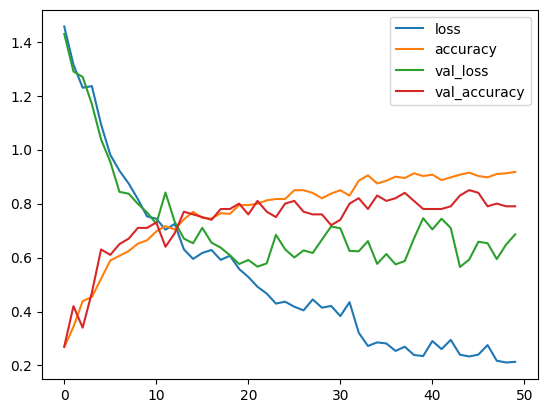

In [ ]:
plot_history(history1)

4/4 [==============================] - 0s 3ms/step
Evaluation result for ResNet152+CNN
****************************
Classification report
              precision    recall  f1-score   support

           1       0.92      0.82      0.87        28
           2       0.67      0.89      0.76        18
           3       0.88      0.60      0.71        25
           4       0.74      0.86      0.79        29

    accuracy                           0.79       100
   macro avg       0.80      0.79      0.78       100
weighted avg       0.81      0.79      0.79       100

Class 0:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Class 1:
Accuracy: 0.93
Precision: 0.92
Recall: 0.82
F1 Score: 0.87
Class 2:
Accuracy: 0.90
Precision: 0.67
Recall: 0.89
F1 Score: 0.76
Class 3:
Accuracy: 0.88
Precision: 0.88
Recall: 0.60
F1 Score: 0.71
Class 4:
Accuracy: 0.87
Precision: 0.74
Recall: 0.86
F1 Score: 0.79
Macro Averages:
Macro Precision: 0.84
Macro Recall: 0.83
Macro F1 Score: 0.83
Micro Ave

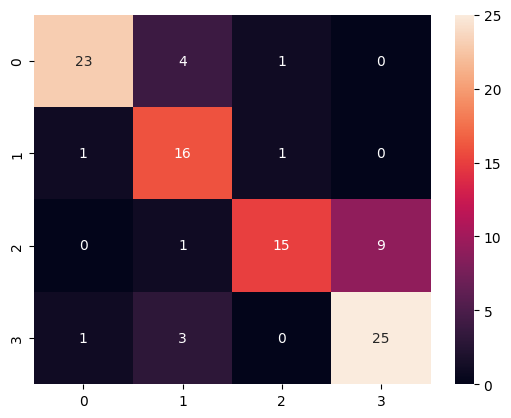

In [ ]:
y_preps2 = model1.predict(x_test)
y_preds2 = np.argmax(y_preps2,axis=1)

lst_cnn = evaluate(y_test,y_preds2,"ResNet152+CNN")
acc_cnn = lst_cnn[0]
acc_cnn_class = lst_cnn[1]
pre_cnn = lst_cnn[2]
rec_cnn = lst_cnn[3]
fscore_cnn = lst_cnn[4]

In [ ]:
rf.fit(img_eff,labels)

RandomForestClassifier(random_state=42)

In [ ]:
feature_importances = rf.feature_importances_

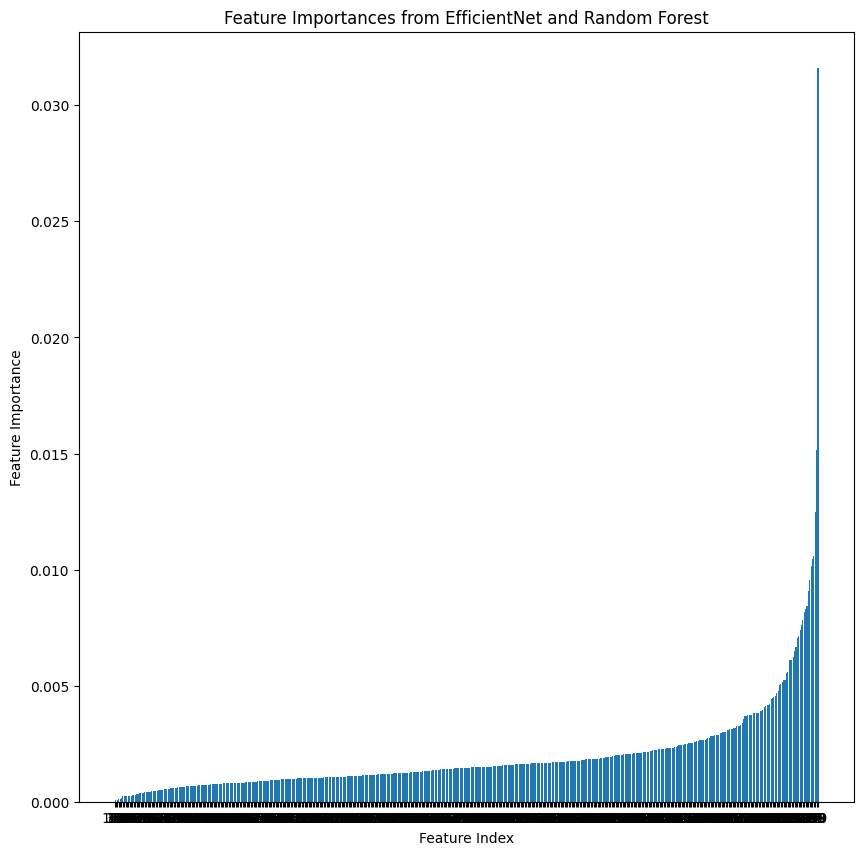

In [ ]:
sorted_indices = feature_importances.argsort()
plt.figure(figsize=(10,10))
plt.bar(range(x.shape[1]), feature_importances[sorted_indices])
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance")
plt.title("Feature Importances from EfficientNet and Random Forest")
plt.xticks(range(x.shape[1]), sorted_indices)
plt.show()

In [ ]:
num_selected_features =int(0.75*len(feature_importances))
selected_feature_indices = np.argsort(feature_importances)[::-1][:num_selected_features]
selected_features = img_eff[:, selected_feature_indices]

In [ ]:
print("Number ofselected features using feature importance: ", num_selected_features)

Number ofselected features using feature importance:  384


In [ ]:
x_train_fi,x_test_fi,y_train_fi,y_test_fi = train_test_split(selected_features,labels,test_size=0.2,random_state=42)

In [ ]:
rf.fit(x_train_fi,y_train_fi)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred_fi_rf = rf.predict(x_test_fi)

Evaluation result for ResNet152 + FeatureImportance + RandomForest
****************************
Classification report
              precision    recall  f1-score   support

           1       0.88      0.79      0.83        28
           2       0.52      0.78      0.62        18
           3       0.74      0.68      0.71        25
           4       0.80      0.69      0.74        29

    accuracy                           0.73       100
   macro avg       0.73      0.73      0.73       100
weighted avg       0.76      0.73      0.74       100

Class 0:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Class 1:
Accuracy: 0.91
Precision: 0.88
Recall: 0.79
F1 Score: 0.83
Class 2:
Accuracy: 0.83
Precision: 0.52
Recall: 0.78
F1 Score: 0.62
Class 3:
Accuracy: 0.86
Precision: 0.74
Recall: 0.68
F1 Score: 0.71
Class 4:
Accuracy: 0.86
Precision: 0.80
Recall: 0.69
F1 Score: 0.74
Macro Averages:
Macro Precision: 0.79
Macro Recall: 0.79
Macro F1 Score: 0.78
Micro Averages:
Micro Precisi

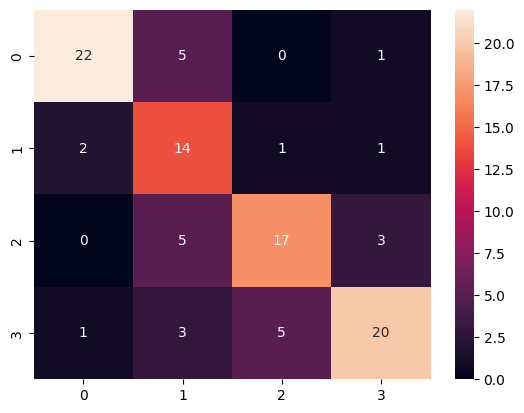

In [ ]:
lst_fi_rf = evaluate(y_test,y_pred_fi_rf,"ResNet152 + FeatureImportance + RandomForest")
acc_fi_rf = lst_fi_rf[0]
acc_fi_rf_class = lst_fi_rf[1]
pre_fi_rf = lst_fi_rf[2]
rec_fi_rf = lst_fi_rf[3]
fscore_fi_rf = lst_fi_rf[4]

In [ ]:
sns.set()
pca = PCA()
pca.fit(img_eff)
explained_variance_ratio = pca.explained_variance_ratio_

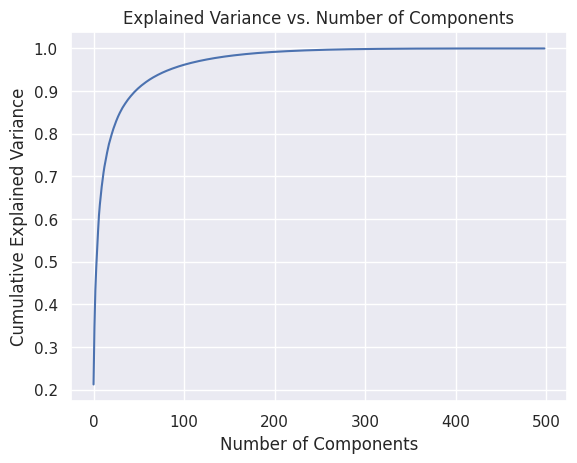

In [ ]:
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

In [ ]:
desired_variance = 0.90
n_components = np.argmax(np.cumsum(explained_variance_ratio) >= desired_variance) + 1
print("Number of components to retain:", n_components)

Number of components to retain: 48


In [ ]:
pca = PCA(n_components=n_components,random_state=42)
X_pca = pca.fit_transform(img_eff)

In [ ]:
x_train_pca,x_test_pca,y_train_pca,y_test_pca = train_test_split(X_pca,labels,test_size=0.2,random_state=42)

In [ ]:
rf.fit(x_train_pca,y_train_pca)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred_pca_rf = rf.predict(x_test_pca)

Evaluation result for Efficientnet + PCA + RandomForest
****************************
Classification report
              precision    recall  f1-score   support

           1       0.88      0.82      0.85        28
           2       0.64      0.78      0.70        18
           3       0.90      0.72      0.80        25
           4       0.78      0.86      0.82        29

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.79       100
weighted avg       0.81      0.80      0.80       100

Class 0:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Class 1:
Accuracy: 0.92
Precision: 0.88
Recall: 0.82
F1 Score: 0.85
Class 2:
Accuracy: 0.88
Precision: 0.64
Recall: 0.78
F1 Score: 0.70
Class 3:
Accuracy: 0.91
Precision: 0.90
Recall: 0.72
F1 Score: 0.80
Class 4:
Accuracy: 0.89
Precision: 0.78
Recall: 0.86
F1 Score: 0.82
Macro Averages:
Macro Precision: 0.84
Macro Recall: 0.84
Macro F1 Score: 0.83
Micro Averages:
Micro Precision: 0.80
Mi

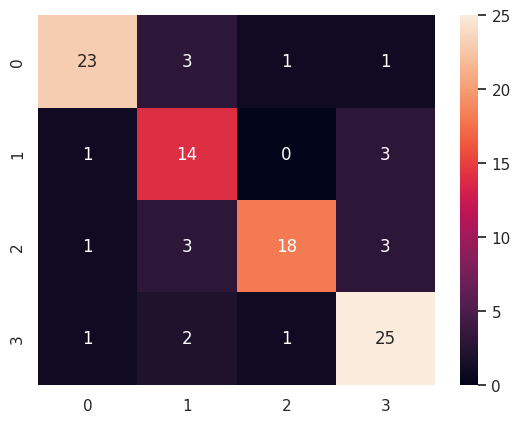

In [ ]:
lst_pca_rf = evaluate(y_test_pca,y_pred_pca_rf,"Efficientnet + PCA + RandomForest")
acc_pca_rf = lst_pca_rf[0]
acc_pca_rf_class = lst_pca_rf[1]
pre_pca_rf = lst_pca_rf[2]
rec_pca_rf = lst_pca_rf[3]
fscore_pca_rf = lst_pca_rf[4]

In [ ]:
y_train_fi_encoded = tf.keras.utils.to_categorical(y_train_fi)
y_test_fi_encoded = tf.keras.utils.to_categorical(y_test_fi)

In [ ]:
dropout_values = [0.2,0.3,0.4]
l2_regularization_strengths = [0.001, 0.01, 0.1]

best_val_accuracy = 0.0
best_dropout = None
best_l2_strength = None
best_weight1 = None

In [ ]:
for dropout in dropout_values:
    for l2_strength in l2_regularization_strengths:
        model_pca = tf.keras.Sequential([
            tf.keras.layers.Dense(128,activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64,activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(32,activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(32,activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(5, activation='softmax')
        ])
        model_pca.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
        tf.random.set_seed(42)
        tf.random.set_seed(42)
        history_pca = model_pca.fit(x_train_fi,y_train_fi_encoded,validation_data=(x_test_fi,y_test_fi_encoded),epochs=50)
        val_loss, val_accuracy = model_pca.evaluate(x_test_fi, y_test_fi_encoded, verbose=0)
        weights = model_pca.get_weights()
        print(f"Dropout: {dropout}, L2 Strength: {l2_strength}, Validation Accuracy: {val_accuracy:.4f}")
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_dropout = dropout
            best_l2_strength = l2_strength
            best_weight1 = weights

print(f"\nBest Dropout: {best_dropout}, Best L2 Strength: {best_l2_strength}, Best Validation Accuracy: {best_val_accuracy:.4f}")

Epoch 1/50
13/13 [==============================] - 2s 22ms/step - loss: 1.8012 - accuracy: 0.2180 - val_loss: 1.5631 - val_accuracy: 0.2700
Epoch 2/50
13/13 [==============================] - 0s 6ms/step - loss: 1.5927 - accuracy: 0.3133 - val_loss: 1.5156 - val_accuracy: 0.3700
Epoch 3/50
13/13 [==============================] - 0s 8ms/step - loss: 1.5676 - accuracy: 0.2832 - val_loss: 1.5084 - val_accuracy: 0.3600
Epoch 4/50
13/13 [==============================] - 0s 6ms/step - loss: 1.5431 - accuracy: 0.2857 - val_loss: 1.5020 - val_accuracy: 0.3700
Epoch 5/50
13/13 [==============================] - 0s 7ms/step - loss: 1.4934 - accuracy: 0.3033 - val_loss: 1.4390 - val_accuracy: 0.4600
Epoch 6/50
13/13 [==============================] - 0s 7ms/step - loss: 1.4661 - accuracy: 0.3158 - val_loss: 1.3514 - val_accuracy: 0.4300
Epoch 7/50
13/13 [==============================] - 0s 7ms/step - loss: 1.4087 - accuracy: 0.3634 - val_loss: 1.2930 - val_accuracy: 0.4300
Epoch 8/50
13/13 [=

In [ ]:
model_fi = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train_fi.shape[1:]),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])
#model_pca.set_weights(best_weight1)

In [ ]:
model_fi.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.004),metrics=['accuracy'])

In [ ]:
history_fi = model_fi.fit(x_train_fi,y_train_fi_encoded,validation_data=(x_test_fi,y_test_fi_encoded),epochs=50)

Epoch 1/50
13/13 [==============================] - 4s 31ms/step - loss: 1.8685 - accuracy: 0.2732 - val_loss: 1.4466 - val_accuracy: 0.4500
Epoch 2/50
13/13 [==============================] - 0s 11ms/step - loss: 1.5332 - accuracy: 0.2757 - val_loss: 1.4762 - val_accuracy: 0.2400
Epoch 3/50
13/13 [==============================] - 0s 16ms/step - loss: 1.5112 - accuracy: 0.2882 - val_loss: 1.4766 - val_accuracy: 0.3000
Epoch 4/50
13/13 [==============================] - 0s 14ms/step - loss: 1.4397 - accuracy: 0.2832 - val_loss: 1.4044 - val_accuracy: 0.2700
Epoch 5/50
13/13 [==============================] - 0s 11ms/step - loss: 1.3901 - accuracy: 0.3283 - val_loss: 1.3246 - val_accuracy: 0.5700
Epoch 6/50
13/13 [==============================] - 0s 13ms/step - loss: 1.3635 - accuracy: 0.3409 - val_loss: 1.3377 - val_accuracy: 0.3000
Epoch 7/50
13/13 [==============================] - 0s 15ms/step - loss: 1.3855 - accuracy: 0.3409 - val_loss: 1.2757 - val_accuracy: 0.2900
Epoch 8/50
13

<Axes: >

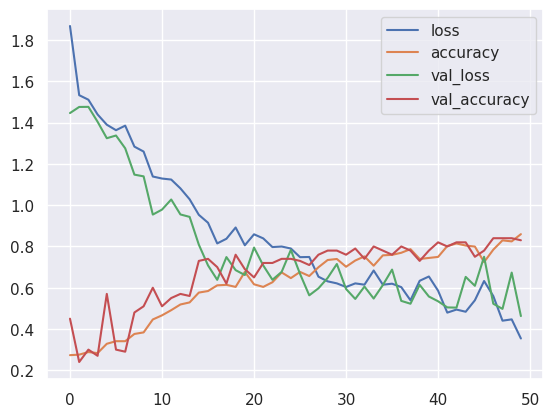

In [ ]:
pd.DataFrame(history_fi.history).plot()

4/4 [==============================] - 0s 8ms/step
Evaluation result for ResNet152+FI+ANN
****************************
Classification report
              precision    recall  f1-score   support

           1       1.00      0.86      0.92        28
           2       0.65      0.94      0.77        18
           3       0.95      0.72      0.82        25
           4       0.77      0.83      0.80        29

    accuracy                           0.83       100
   macro avg       0.84      0.84      0.83       100
weighted avg       0.86      0.83      0.83       100

Class 0:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Class 1:
Accuracy: 0.96
Precision: 1.00
Recall: 0.86
F1 Score: 0.92
Class 2:
Accuracy: 0.90
Precision: 0.65
Recall: 0.94
F1 Score: 0.77
Class 3:
Accuracy: 0.92
Precision: 0.95
Recall: 0.72
F1 Score: 0.82
Class 4:
Accuracy: 0.88
Precision: 0.77
Recall: 0.83
F1 Score: 0.80
Macro Averages:
Macro Precision: 0.88
Macro Recall: 0.87
Macro F1 Score: 0.86
Micro 

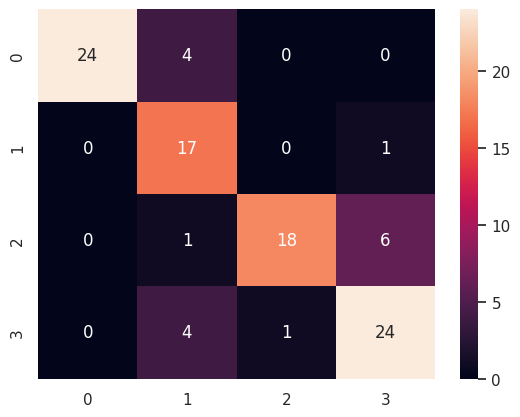

In [ ]:
y_preps3 = model_fi.predict(x_test_fi)
y_preds3 = np.argmax(y_preps3,axis=1)

lst_fi_ann = evaluate(y_test,y_preds3,"ResNet152+FI+ANN")
acc_fi_ann = lst_fi_ann[0]
acc_fi_ann_class = lst_fi_ann[1]
pre_fi_ann = lst_fi_ann[2]
rec_fi_ann = lst_fi_ann[3]
fscore_fi_ann = lst_fi_ann[4]

In [ ]:
y_train_pca_encoded = tf.keras.utils.to_categorical(y_train_pca)
y_test_pca_encoded = tf.keras.utils.to_categorical(y_test_pca)

In [ ]:
dropout_values = [0.2,0.3,0.4]
l2_regularization_strengths = [0.001, 0.01, 0.1]

best_val_accuracy = 0.0
best_dropout = None
best_l2_strength = None
best_weight = None

In [ ]:
for dropout in dropout_values:
    for l2_strength in l2_regularization_strengths:
        model_pca = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=x_train_pca.shape[1:]),
            tf.keras.layers.Dense(128,activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64,activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(32,activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(32,activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(5, activation='softmax')
        ])
        model_pca.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
        history_pca = model_pca.fit(x_train_pca,y_train_pca_encoded,validation_data=(x_test_pca,y_test_pca_encoded),epochs=50)
        val_loss, val_accuracy = model_pca.evaluate(x_test_pca, y_test_pca_encoded, verbose=0)
        weight = model_pca.get_weights()
        print(f"Dropout: {dropout}, L2 Strength: {l2_strength}, Validation Accuracy: {val_accuracy:.4f}")
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_dropout = dropout
            best_l2_strength = l2_strength
            best_weight = weight

print(f"\nBest Dropout: {best_dropout}, Best L2 Strength: {best_l2_strength}, Best Validation Accuracy: {best_val_accuracy:.4f}")

Epoch 1/50
13/13 [==============================] - 3s 21ms/step - loss: 1.7258 - accuracy: 0.2556 - val_loss: 1.4214 - val_accuracy: 0.3100
Epoch 2/50
13/13 [==============================] - 0s 7ms/step - loss: 1.5223 - accuracy: 0.3158 - val_loss: 1.3697 - val_accuracy: 0.3300
Epoch 3/50
13/13 [==============================] - 0s 6ms/step - loss: 1.4717 - accuracy: 0.3759 - val_loss: 1.3119 - val_accuracy: 0.4700
Epoch 4/50
13/13 [==============================] - 0s 6ms/step - loss: 1.4954 - accuracy: 0.2957 - val_loss: 1.2774 - val_accuracy: 0.4700
Epoch 5/50
13/13 [==============================] - 0s 7ms/step - loss: 1.3470 - accuracy: 0.3734 - val_loss: 1.2198 - val_accuracy: 0.5400
Epoch 6/50
13/13 [==============================] - 0s 8ms/step - loss: 1.3235 - accuracy: 0.4486 - val_loss: 1.1691 - val_accuracy: 0.5600
Epoch 7/50
13/13 [==============================] - 0s 7ms/step - loss: 1.2859 - accuracy: 0.3935 - val_loss: 1.1135 - val_accuracy: 0.6000
Epoch 8/50
13/13 [=

In [ ]:
model_pca = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])
#model_pca.set_weights(best_weight)

In [ ]:
model_pca.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
history_pca = model_pca.fit(x_train_pca,y_train_pca_encoded,validation_data=(x_test_pca,y_test_pca_encoded),epochs=50)

Epoch 1/50
13/13 [==============================] - 2s 31ms/step - loss: 1.8072 - accuracy: 0.2206 - val_loss: 1.4922 - val_accuracy: 0.3300
Epoch 2/50
13/13 [==============================] - 0s 11ms/step - loss: 1.5876 - accuracy: 0.2757 - val_loss: 1.4516 - val_accuracy: 0.3800
Epoch 3/50
13/13 [==============================] - 0s 11ms/step - loss: 1.4427 - accuracy: 0.3784 - val_loss: 1.3899 - val_accuracy: 0.4600
Epoch 4/50
13/13 [==============================] - 0s 11ms/step - loss: 1.4261 - accuracy: 0.3308 - val_loss: 1.3439 - val_accuracy: 0.4900
Epoch 5/50
13/13 [==============================] - 0s 11ms/step - loss: 1.4265 - accuracy: 0.3409 - val_loss: 1.2954 - val_accuracy: 0.5500
Epoch 6/50
13/13 [==============================] - 0s 11ms/step - loss: 1.3500 - accuracy: 0.3709 - val_loss: 1.2462 - val_accuracy: 0.5800
Epoch 7/50
13/13 [==============================] - 0s 11ms/step - loss: 1.2968 - accuracy: 0.4261 - val_loss: 1.1719 - val_accuracy: 0.5900
Epoch 8/50
13

<Axes: >

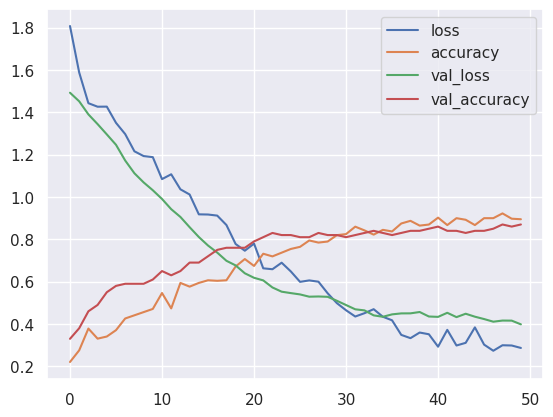

In [ ]:
pd.DataFrame(history_pca.history).plot()

4/4 [==============================] - 0s 3ms/step
Evaluation result for ResNet+PCA+ANN
****************************
Classification report
              precision    recall  f1-score   support

           1       0.86      0.86      0.86        28
           2       0.74      0.94      0.83        18
           3       0.96      0.88      0.92        25
           4       0.92      0.83      0.87        29

    accuracy                           0.87       100
   macro avg       0.87      0.88      0.87       100
weighted avg       0.88      0.87      0.87       100

Class 0:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Class 1:
Accuracy: 0.92
Precision: 0.86
Recall: 0.86
F1 Score: 0.86
Class 2:
Accuracy: 0.93
Precision: 0.74
Recall: 0.94
F1 Score: 0.83
Class 3:
Accuracy: 0.96
Precision: 0.96
Recall: 0.88
F1 Score: 0.92
Class 4:
Accuracy: 0.93
Precision: 0.92
Recall: 0.83
F1 Score: 0.87
Macro Averages:
Macro Precision: 0.90
Macro Recall: 0.90
Macro F1 Score: 0.90
Micro Av

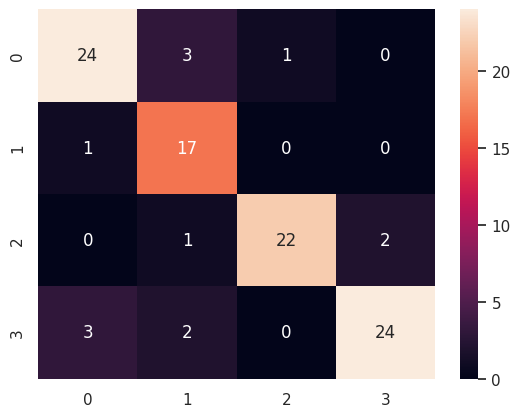

In [ ]:
y_preps4 = model_pca.predict(x_test_pca)
y_preds4 = np.argmax(y_preps4,axis=1)

lst_pca_ann = evaluate(y_test,y_preds4,"ResNet+PCA+ANN")
acc_pca_ann = lst_pca_ann[0]
acc_pca_ann_class = lst_pca_ann[1]
pre_pca_ann = lst_pca_ann[2]
rec_pca_ann = lst_pca_ann[3]
fscore_pca_ann = lst_pca_ann[4]

In [ ]:
precision = list(pre_rf.values())
recall = list(rec_rf.values())
classes = ['Mild','Moderate','No DR','PDR', 'Severe']

In [ ]:
study1 = pd.DataFrame()
study1['Classes'] = classes
study1['Precision'] = precision
study1['Recall'] = recall
study1

,Classes,Precision,Recall
0,Mild,1.000000,1.000000
1,Moderate,0.950000,0.678571
2,No DR,0.566667,0.944444
3,PDR,0.809524,0.680000
4,Severe,0.793103,0.793103


In [ ]:
study1.to_csv('Study1_vgg.csv',index=False)

In [ ]:
models = ['vgg+RF','vgg+ANN']
acc = [acc_pca_rf,acc_pca_ann]

In [ ]:
study2 = pd.DataFrame()
study2['Models'] = models
study2['Accuracy'] = acc
study2

,Models,Accuracy
0,vgg+RF,0.80
1,vgg+ANN,0.87


In [ ]:
study2.to_csv('Study2_vgg.csv',index=False)

In [ ]:
models = ['vgg+RF','vgg+ANN']
acc = [acc_fi_rf,acc_fi_ann]

In [ ]:
study3 = pd.DataFrame()
study3['Models'] = models
study3['Accuracy'] = acc
study3

,Models,Accuracy
0,vgg+RF,0.73
1,vgg+ANN,0.83


In [ ]:
study3.to_csv('Study3_vgg.csv',index=False)

In [ ]:
models = ['vgg+RF','vgg+PCA+RF','vgg+FI+RF','vgg+ANN','vgg+PCA+ANN','vgg+FI+ANN']
acc = [acc_rf,acc_pca_rf,acc_fi_rf,acc_ann,acc_pca_ann,acc_fi_ann]

In [ ]:
study4 = pd.DataFrame()
study4['Models'] = models
study4['Accuracy'] = acc
study4

,Models,Accuracy
0,vgg+RF,0.76
1,vgg+PCA+RF,0.80
2,vgg+FI+RF,0.73
3,vgg+ANN,0.82
4,vgg+PCA+ANN,0.87
5,vgg+FI+ANN,0.83


In [ ]:
study4.to_csv('Study4_vgg.csv',index=False)